In [1]:
from datetime import datetime

import pandas as pd
from energy_box_control.power_hub.control import control_power_hub, initial_control_state
from energy_box_control.power_hub.network import PowerHub, PowerHubSchedules
from energy_box_control.schedules import ConstSchedule

import matplotlib.pylab as plt

%load_ext autoreload 
%autoreload 2

In [16]:
from datetime import timedelta
from energy_box_control.power_hub.control import initial_control_all_off


results = {}
control_results = {}

schedules = PowerHubSchedules(
    global_irradiance_schedule=ConstSchedule(800),
    cooling_demand_schedule=ConstSchedule(100000 / 24),
)
power_hub = PowerHub.power_hub(schedules)
steps = 500
step_size = 60

control_state = initial_control_state()

state = power_hub.simple_initial_state(datetime.now(), timedelta(seconds=step_size))
control_values = initial_control_all_off(power_hub)
power_hub_sensors = power_hub.sensors_from_state(state)

for _ in range(steps):
    state = power_hub.simulate(state, control_values)
    

    sensors = power_hub.sensors_from_state(state)
    control_state, control_values = control_power_hub(
        power_hub, control_state, sensors, state.time
    )
    # control_values = no_control(power_hub)

    control_results[state.time.timestamp] = pd.DataFrame(
        {**{
            key: item.__dict__
            for key, item in control_values.name_to_control_values_mapping(
                power_hub
            ).items()
        },**{'control_mode':{key: item.control_mode._value_ for key, item in control_state.__dict__.items() if key != 'setpoints'}}}
    ).T.stack()
    results[state.time.timestamp] = pd.DataFrame(sensors.to_dict()).T.stack()

control_data = pd.DataFrame(control_results).T[1::]
data = pd.DataFrame(results).T[1::]

In [6]:
from datetime import timedelta
from energy_box_control.power_hub.control import no_control


results = {}

schedules = PowerHubSchedules(
    global_irradiance_schedule=ConstSchedule(800),
    cooling_demand_schedule=ConstSchedule(100000 / 24),
)
power_hub = PowerHub.power_hub(schedules)
steps = 500
step_size = 60

control_state = initial_control_state()

state = power_hub.simple_initial_state(datetime.now(), timedelta(seconds=step_size))
control_values = no_control(power_hub)
power_hub_sensors = power_hub.sensors_from_state(state)

for _ in range(steps):
    state = power_hub.simulate(state, control_values)
    

    sensors = power_hub.sensors_from_state(state)
    
    results[state.time.timestamp] = pd.DataFrame(sensors.to_dict()).T.stack()


data = pd.DataFrame(results).T[1::]

In [17]:
#test for powers summing to 0 and come up with convention for sign 

#test consistency of flows

#implement real schedules 

In [18]:
appliances = ["heat_pipes", "hot_reservoir", "pcm", "yazaki", "chiller", "preheat_reservoir", "outboard_exchange", "cold_reservoir"]
temperatures = [(appliance,var) for appliance, var in data.columns if 'temperature' in var and appliance in appliances]
powers = [(appliance,var) for appliance, var in data.columns if 'power' in var and appliance in appliances]
flows = [(appliance,var) for appliance, var in data.columns if 'flow' in var and appliance in appliances]

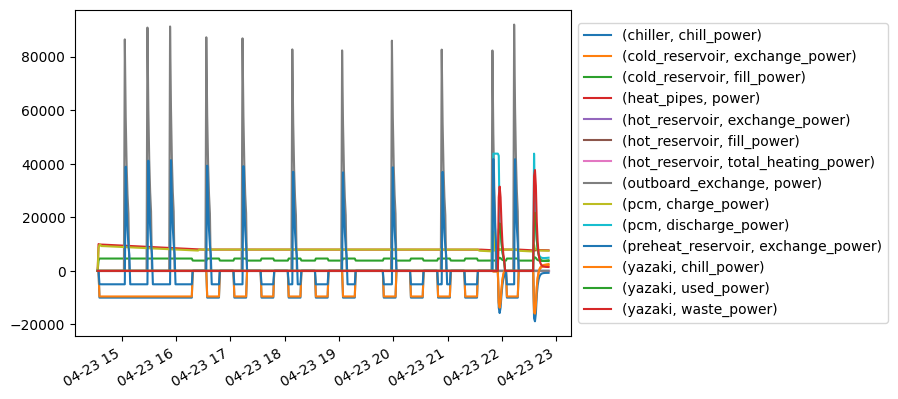

In [19]:
data[powers].plot()#marker ='.', ls = 'none')
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

<Axes: >

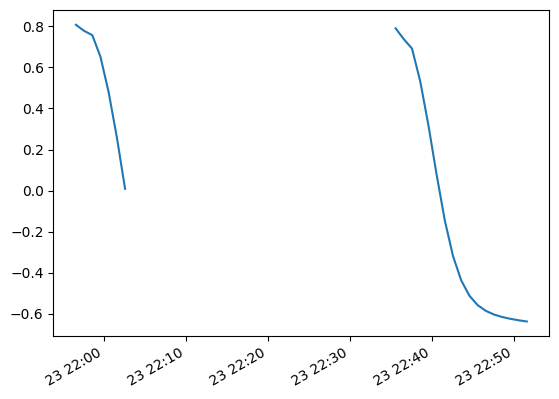

In [21]:
data.yazaki.efficiency.plot()

In [22]:
data[powers]

chiller cold_reservoir               \
                           chill_power exchange_power   fill_power   
2024-04-23 14:33:32.455307         0.0            0.0          0.0   
2024-04-23 14:34:32.455307         0.0           -0.0  3831.417625   
2024-04-23 14:35:32.455307    -10000.0   -9565.602837   4601.06383   
2024-04-23 14:36:32.455307    -10000.0   -9565.602837   4601.06383   
2024-04-23 14:37:32.455307    -10000.0   -9565.602837   4601.06383   
...                                ...            ...          ...   
2024-04-23 22:47:32.455307         0.0    1818.114298  3685.132566   
2024-04-23 22:48:32.455307         0.0    1878.988806  3680.234617   
2024-04-23 22:49:32.455307         0.0    1932.893332  3675.897471   
2024-04-23 22:50:32.455307         0.0    1982.764034  3671.884886   
2024-04-23 22:51:32.455307         0.0    2030.201649  3668.068067   

                             heat_pipes  hot_reservoir             \
                                  power exchange_power fill_power   
2024-04-23 14:33:32.455307          0.0            0.0        0.0   
2024-04-23 14:34:32.455307     10001.68            0.0        0.0   
2024-04-23 14:35:32.455307  9857.984791            0.0        0.0   
2024-04-23 14:36:32.455307  9817.324946            0.0        0.0   
2024-04-23 14:37:32.455307  9813.817287            0.0        0.0   
...                                 ...            ...        ...   
2024-04-23 22:47:32.455307  7718.692586            0.0        0.0   
2024-04-23 22:48:32.455307  7710.953644            0.0        0.0   
2024-04-23 22:49:32.455307   7703.25423            0.0        0.0   
2024-04-23 22:50:32.455307  7695.615355            0.0        0.0   
2024-04-23 22:51:32.455307  7688.048038            0.0        0.0   

                                               outboard_exchange          pcm  \
                           total_heating_power             power charge_power   
2024-04-23 14:33:32.455307                -0.0               0.0          0.0   
2024-04-23 14:34:32.455307                -0.0               0.0  8547.838323   
2024-04-23 14:35:32.455307                -0.0               0.0  9719.083305   
2024-04-23 14:36:32.455307                -0.0               0.0  9757.420719   
2024-04-23 14:37:32.455307                -0.0               0.0  9267.307022   
...                                        ...               ...          ...   
2024-04-23 22:47:32.455307                -0.0               0.0   7532.47263   
2024-04-23 22:48:32.455307                -0.0               0.0  7526.354514   
2024-04-23 22:49:32.455307                -0.0               0.0  7520.542406   
2024-04-23 22:50:32.455307                -0.0               0.0  7514.923415   
2024-04-23 22:51:32.455307                -0.0               0.0  7509.435848   

                                           preheat_reservoir       yazaki  \
                           discharge_power    exchange_power  chill_power   
2024-04-23 14:33:32.455307             0.0               0.0          0.0   
2024-04-23 14:34:32.455307             0.0               0.0          0.0   
2024-04-23 14:35:32.455307             0.0           -5000.0          0.0   
2024-04-23 14:36:32.455307             0.0           -5018.0          0.0   
2024-04-23 14:37:32.455307             0.0           -5018.0          0.0   
...                                    ...               ...          ...   
2024-04-23 22:47:32.455307     4788.083976       -773.057299  2299.648399   
2024-04-23 22:48:32.455307     4811.469655       -756.121479  2365.420856   
2024-04-23 22:49:32.455307     4840.136018       -746.291379  2423.662527   
2024-04-23 22:50:32.455307     4871.474351       -740.324712  2477.545814   
2024-04-23 22:51:32.455307     4904.067595       -736.457178  2528.800249   

                                                      
                             used_power  waste_power  
2024-04-23 14:33:32.455307          0.0          0.0  
2

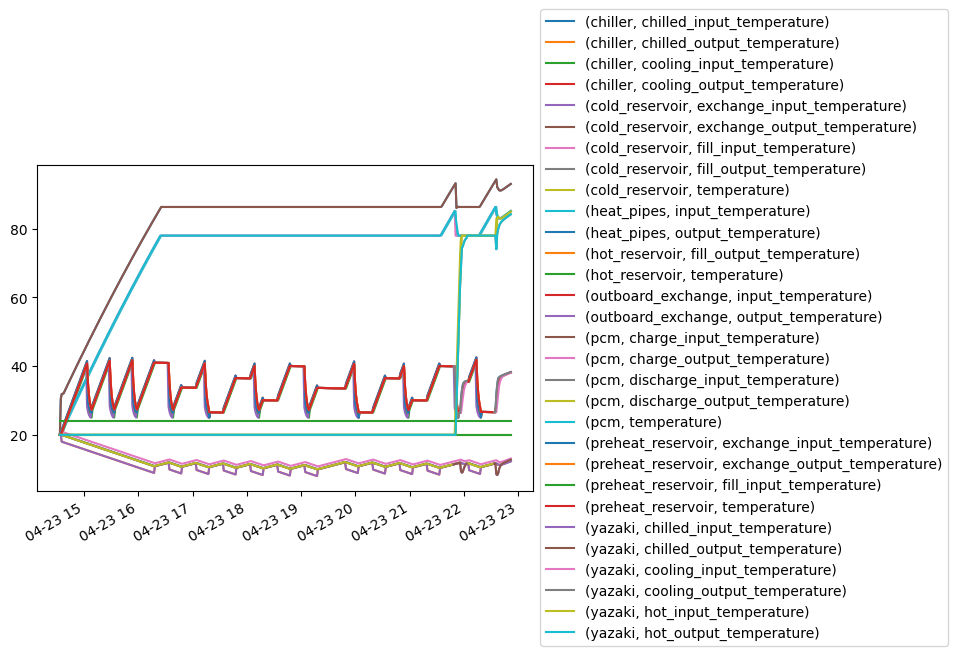

In [23]:
data[temperatures].plot()
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))